In [1]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

In [3]:
# reading bank data into dataframe
df = pd.read_csv('data/bank-full.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Now we'll look at each object-type column to see how to turn it into numeric data

In [6]:
df['job'].value_counts()

# keeping, turning into binary by splitting jobs into lower income (0) and higher income(1)

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [7]:
df['marital'].value_counts()

# keeping, converting single and divorced into 0, and married into 1

marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

In [8]:
df['education'].value_counts()

# keeping, converting to ordinal (primary - 1, secondary - 2, tertiary - 3)

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [9]:
df['default'].value_counts()

# keeping, converting to binary

default
no     44396
yes      815
Name: count, dtype: int64

In [10]:
df['housing'].value_counts()

# keeping, converting to binary

housing
yes    25130
no     20081
Name: count, dtype: int64

In [11]:
df['loan'].value_counts()

# keeping, converting to binary

loan
no     37967
yes     7244
Name: count, dtype: int64

In [12]:
# will remove contact, day, month and duration columns. All of these are related to each other and they can't really be combined into a single column.

In [13]:
df['poutcome'].value_counts()

# removing, too many unknown values

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [14]:
df['y'].value_counts()

# target, converting to binary

y
no     39922
yes     5289
Name: count, dtype: int64

### Data Preparation

In [16]:
# removing rows with unknown values
df = df.loc[df['job'] != 'unknown'] 
df = df.loc[df['education'] != 'unknown'] 

In [17]:
# removing undesired columns
to_remove = ['contact', 'day', 'month', 'duration', 'poutcome']
df = df.drop(columns=to_remove)

In [18]:
# mapping values to binary, and education to ordinal
df['job'] = df['job'].map({'blue-collar': 0, 'services': 0, 'retired': 0, 'unemployed': 0, 'housemaid': 0, 'student': 0, 'management': 1, 
                           'technician': 1, 'admin.': 1, 'self-employed': 1, 'entrepreneur': 1})
df['marital'] = df['marital'].map({'single': 0, 'divorced': 0, 'married': 1})
df['education'] = df['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [19]:
# final dataframe to be used for modelling
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43193 entries, 0 to 45210
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        43193 non-null  int64
 1   job        43193 non-null  int64
 2   marital    43193 non-null  int64
 3   education  43193 non-null  int64
 4   default    43193 non-null  int64
 5   balance    43193 non-null  int64
 6   housing    43193 non-null  int64
 7   loan       43193 non-null  int64
 8   campaign   43193 non-null  int64
 9   pdays      43193 non-null  int64
 10  previous   43193 non-null  int64
 11  y          43193 non-null  int64
dtypes: int64(12)
memory usage: 4.3 MB


In [20]:
# setting features and target variable
X = df.drop('y', axis=1)
y = df['y']

In [21]:
# splitting train and test data, default 0.3 test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Modelling and Testing

We will fit the train data into all four classifier and test them against the training and test sets. Fit times and testing times will be measured.

In [24]:
%%time
lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)

CPU times: total: 12 s
Wall time: 4.51 s


In [25]:
lr_train = lr.score(X_train, y_train)
print(lr_train)

0.8830825202579792


In [26]:
%%time
lr_test = lr.score(X_test, y_test)
print(lr_test)

0.8835468436487112
CPU times: total: 0 ns
Wall time: 4.99 ms


In [27]:
%%time
knn = KNeighborsClassifier().fit(X_train, y_train)

CPU times: total: 125 ms
Wall time: 68.9 ms


In [28]:
knn_train = knn.score(X_train, y_train)
print(knn_train)

0.8970398544732926


In [29]:
%%time
knn_test = knn.score(X_test, y_test)
print(knn_test)

0.8765241549621855
CPU times: total: 297 ms
Wall time: 494 ms


In [30]:
%%time
svc = SVC().fit(X_train, y_train)

CPU times: total: 4.83 s
Wall time: 7.39 s


In [31]:
svc_train = svc.score(X_train, y_train)
print(svc_train)

0.8837109310401852


In [32]:
%%time
svc_test = svc.score(X_test, y_test)
print(svc_test)

0.884009878067603
CPU times: total: 4.34 s
Wall time: 6.26 s


In [33]:
%%time
dtree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 101 ms


In [34]:
dt_train = dtree.score(X_train, y_train)
print(dt_train)

0.998180916156772


In [35]:
%%time
dt_test = dtree.score(X_test, y_test)
print(dt_test)

0.8104645778669548
CPU times: total: 0 ns
Wall time: 6.49 ms


### Results

In [37]:
# lists for dictionary
labels = ['LogisticRegression', 'KNearestNeighbors', 'SVMClassifier', 'DecisionTree']
train_accs = [lr_train, knn_train, svc_train, dt_train]
test_accs = [lr_test, knn_test, svc_test, dt_test]
fit_times = [7360, 93.8, 4610, 62.5] # in ms, hardcoded since %%time values cant be passed to a variable
test_times = [0, 281, 4420, 0] # in ms, hardcoded since %%time values cant be passed to a variable
# PC INFO: Intel Core i5-1140 @ 2.6 GHz

results = {
   'classifier': labels,
    'fit_time (ms)': fit_times,
    'test_time (ms)': test_times,
    'train_acc': train_accs,
    'test_acc': test_accs
}

# creating results dataframe from dictionary
results_df = pd.DataFrame(results).set_index('classifier')
results_df

,fit_time (ms),test_time (ms),train_acc,test_acc
classifier,,,,
LogisticRegression,7360.0,0,0.883083,0.883547
KNearestNeighbors,93.8,281,0.897040,0.876524
SVMClassifier,4610.0,4420,0.883711,0.884010
DecisionTree,62.5,0,0.998181,0.810465


Text(0, 0.5, 'Test Accuracy')

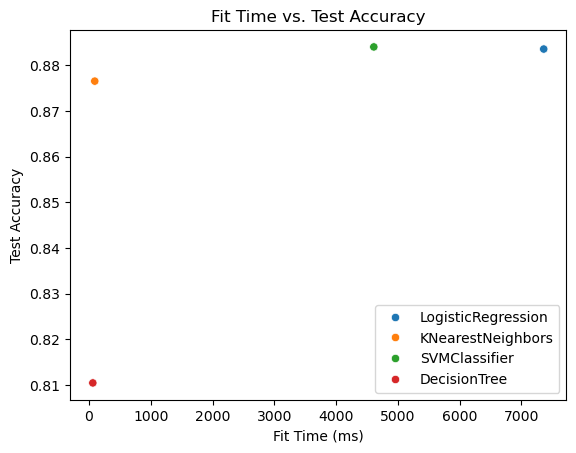

In [38]:
# plotting to find the classifier with the best fit time vs. test accuracy balance
sns.scatterplot(x=fit_times, y=test_accs, hue=labels)
plt.title('Fit Time vs. Test Accuracy')
plt.xlabel('Fit Time (ms)')
plt.ylabel('Test Accuracy')

KNearestNeighbors is the best performing algorithm, with minimal fit time and only a very small penalty when it comes to test accuracy.